In [ ]:
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import sklearn.linear_model, sklearn.neighbors

In [ ]:
def prepare_country_stats(oecd_bli, gdp_per_capita):
    oecd_bli = oecd_bli[oecd_bli["INEQUALITY"]=="TOT"]
    oecd_bli = oecd_bli.pivot(index="Country", columns="Indicator", values="Value")
    gdp_per_capita.rename(columns={"2015": "GDP per capita"}, inplace=True)
    gdp_per_capita.set_index("Country", inplace=True)
    full_country_stats = pd.merge(left=oecd_bli, right=gdp_per_capita,
                                  left_index=True, right_index=True)
    full_country_stats.sort_values(by="GDP per capita", inplace=True)
    remove_indices = [0, 1, 6, 8, 33, 34, 35]
    keep_indices = list(set(range(36)) - set(remove_indices))
    return full_country_stats[["GDP per capita", 'Life satisfaction']].iloc[keep_indices]


oecd_bli = pd.read_csv('datasets/oecd_bli_2015.csv', thousands = ',')
gdp_per_capita = pd.read_csv('datasets/gdp_per_capita.csv', thousands = ',', delimiter = '\t', encoding = 'latin1', na_values = 'n/a')
country_stats = prepare_country_stats(oecd_bli, gdp_per_capita)
X, y = np.c_[country_stats['GDP per capita']], np.c_[country_stats['Life satisfaction']] #vectorize
country_stats.plot(kind = 'scatter', x='GDP per capita', y='Life satisfaction')
model_linear = sklearn.linear_model.LinearRegression()
model_linear.fit(X, y)
model_k_nearest = sklearn.neighbors.KNeighborsRegressor(n_neighbors = 3)
model_k_nearest.fit(X, y)
X_new = [[22587]]
print(model_k_nearest.predict(X_new))
print(model_linear.predict(X_new))
# plt.show()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

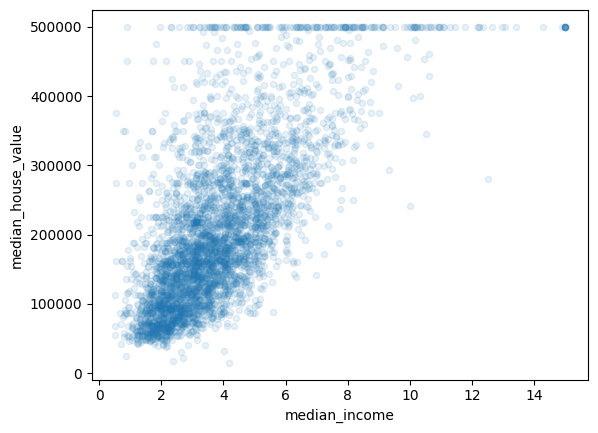

In [280]:
import os
import tarfile
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
import joblib

download_root = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
housing_path = os.path.join("datasets", "housing")
housing_url = download_root + "datasets/housing/housing.tgz"

def get_housing_data(housing_url, housing_path):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, 'housing.tgz')
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

def load_housing_data(housing_path):
    csv_path = os.path.join(housing_path, 'housing.csv')
    df = pd.read_csv(csv_path)
    df['income_cat'] = pd.cut(df['median_income'], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])
    # df['income_cat'].hist()  # classify incomes into bins
    # plt.show()
    return df


get_housing_data(housing_url, housing_path)
df = load_housing_data(housing_path)

train_set, test_set = train_test_split(df, test_size = 0.2, random_state = 42)
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
#ensures both sets would have approximately the  same percentages for each income category as the original dataset
for train_index, test_index in split.split(df, df['income_cat']):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

#drop dummy strat var
strat_test_set['income_cat'].value_counts() / len(strat_test_set)
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis = 1, inplace = True)

housing = strat_test_set.copy()
# housing.plot(kind = 'scatter', x = 'longitude', y = 'latitude', alpha = 0.1)
# housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
#         s=housing["population"]/100, label="population", figsize=(10,7),
#         c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
#     )
# plt.legend()
numeric_columns = housing.select_dtypes(include=[np.number]).columns
corr_matrix = housing[numeric_columns].corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

attributes = ["median_house_value", "median_income", "total_rooms",
                  "housing_median_age"]
# scatter_matrix(housing[attributes], figsize=(12, 8))
housing.plot(kind = 'scatter', x = 'median_income', y = 'median_house_value', alpha = 0.1)

housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

numeric_columns = housing.select_dtypes(include=[np.number]).columns
corr_matrix = housing[numeric_columns].corr()
corr_matrix['median_house_value'].sort_values(ascending = False)

housing = strat_train_set.drop('median_house_value', axis = 1)
housing_labels = strat_train_set['median_house_value'].copy()

#missing vals with median
# housing['total_bedrooms'].fillna(0)
imputer = SimpleImputer(strategy = 'median')
housing_num = housing.drop('ocean_proximity', axis = 1)
imputer.fit(housing_num)
imputer.statistics_
housing_num.median().values
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns = housing_num.columns, index = housing_num.index)

#one hot encode the labels for the ocean_proximity feature
housing_cat = housing[['ocean_proximity']]
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot.toarray()

In [281]:
#Feature scaling 
min_max_scaler = MinMaxScaler(feature_range = (-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_tr)

In [282]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y = None):
        return self 
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [283]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy = 'median')), 
        ('attribs_adder', CombinedAttributesAdder()), 
        ('std_scaler', StandardScaler()),
])
housing_num_tr = num_pipeline.fit_transform(housing_tr)
housing_num_tr

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.01739526,
         0.00622264, -0.12112176],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.56925554,
        -0.04081077, -0.81086696],
       [ 0.26758118, -0.1259716 ,  1.22045984, ..., -0.01802432,
        -0.07537122, -0.33827252],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ..., -0.5092404 ,
        -0.03743619,  0.32286937],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.32814891,
        -0.05915604, -0.45702273],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.01407228,
         0.00657083, -0.12169672]])

In [284]:
from sklearn.compose import ColumnTransformer
num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs), 
    ('cat', OneHotEncoder(), cat_attribs),

])
housing_prepared = full_pipeline.fit_transform(housing)

In [285]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]


In [286]:
print("Labels", list(some_labels))

Labels [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [287]:
from sklearn.metrics import mean_squared_error 
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse #in dollars

68627.87390018745

In [288]:
from sklearn.tree import DecisionTreeRegressor 

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [289]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring = 'neg_mean_squared_error', cv = 10)

tree_rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("STD:", scores.std())

display_scores(tree_rmse_scores)

Scores: [71864.21267304 70885.96278883 70278.20384097 70598.49967807
 69284.14178763 76848.49915083 72766.04111451 75237.98094166
 68399.63519558 70349.43526992]
Mean: 71651.26124410321
STD: 2502.284459031681


In [290]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                         scoring = 'neg_mean_squared_error', cv = 10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean: 69104.07998247063
STD: 2880.3282098180666


In [291]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)

scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                         scoring = 'neg_mean_squared_error', cv = 10)

forest_rmse_scores = np.sqrt(-scores)
display_scores(forest_rmse_scores)

Scores: [50914.76625457 48843.6633247  46650.22567204 51601.92954805
 47768.01117271 52071.89016154 52368.10183211 50085.35455173
 48841.60195274 53842.29812096]
Mean: 50298.78425911557
STD: 2146.2337556057264


In [292]:
joblib.dump(lin_reg, 'lin_reg_model.pkl')

['lin_reg_model.pkl']

In [293]:
loaded = joblib.load('lin_reg_model.pkl')

In [294]:
from sklearn.model_selection import GridSearchCV #good for relatively few combinations
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, 
    {'bootstrap': [False], 'n_estimators':[3, 10], 'max_features':[2, 3, 4]},
]
forest_reg = RandomForestRegressor()

#12 combinations of n_estimators and max_features, 
#6 combinations of hyperparams in second dict
#18 combinations altogether, will train each model 5 times (five 5 cross val)
grid_search = GridSearchCV(forest_reg, param_grid, cv = 5,  
                           scoring = 'neg_mean_squared_error', 
                           return_train_score = True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [295]:
# from sklearn.model_selection import RandomizedSearchCV


# param_distributions = [
#     {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, 
#     {'bootstrap': [False], 'n_estimators':[3, 10], 'max_features':[2, 3, 4]},
# ]
# forest_reg = RandomForestRegressor()

# grid_search = RandomizedSearchCV(forest_reg, param_distributions, cv = 5,  
#                            scoring = 'neg_mean_squared_error', 
#                            return_train_score = True)
# grid_search.fit(housing_prepared, housing_labels)


In [296]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30)

In [297]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)
    

65033.83810480186 {'max_features': 2, 'n_estimators': 3}
55254.71845625245 {'max_features': 2, 'n_estimators': 10}
52966.19808383339 {'max_features': 2, 'n_estimators': 30}
59530.61680485248 {'max_features': 4, 'n_estimators': 3}
52645.861836019736 {'max_features': 4, 'n_estimators': 10}
50190.28349664732 {'max_features': 4, 'n_estimators': 30}
59197.21382522294 {'max_features': 6, 'n_estimators': 3}
51644.79114428688 {'max_features': 6, 'n_estimators': 10}
49650.87860631667 {'max_features': 6, 'n_estimators': 30}
59446.78659236711 {'max_features': 8, 'n_estimators': 3}
52252.752347343805 {'max_features': 8, 'n_estimators': 10}
50155.490933018744 {'max_features': 8, 'n_estimators': 30}
62611.433022287056 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54089.32019451136 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59632.47932045798 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52284.477401141026 {'bootstrap': False, 'max_features': 3, 'n_estimators

In [298]:
feature_importances = grid_search.best_estimator_.feature_importances_

In [299]:
feature_importances

array([7.45898300e-02, 6.95595541e-02, 4.32344432e-02, 1.69774850e-02,
       1.62547230e-02, 1.74679556e-02, 1.64208651e-02, 3.26788357e-01,
       7.25278030e-02, 1.11507880e-01, 7.16884741e-02, 8.10901273e-03,
       1.46469490e-01, 8.00741546e-05, 3.05203436e-03, 5.27201922e-03])

In [300]:
extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']
cat_encoder = full_pipeline.named_transformers_['cat']
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs 
sorted(zip(feature_importances, attributes), reverse = True)

[(0.3267883566497193, 'median_income'),
 (0.14646948974651638, 'INLAND'),
 (0.1115078799440199, 'pop_per_hhold'),
 (0.07458983002299711, 'longitude'),
 (0.07252780300998136, 'rooms_per_hhold'),
 (0.07168847411142536, 'bedrooms_per_room'),
 (0.06955955410894556, 'latitude'),
 (0.043234443218679364, 'housing_median_age'),
 (0.01746795560213477, 'population'),
 (0.016977484954832537, 'total_rooms'),
 (0.0164208651412651, 'households'),
 (0.016254723029136883, 'total_bedrooms'),
 (0.00810901272569793, '<1H OCEAN'),
 (0.00527201921850774, 'NEAR OCEAN'),
 (0.003052034361580353, 'NEAR BAY'),
 (8.007415456052813e-05, 'ISLAND')]

In [301]:
strat_test_set.head(1)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
5241,-118.39,34.12,29.0,6447.0,1012.0,2184.0,960.0,8.2816,500001.0,<1H OCEAN


In [302]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop('median_house_value', axis = 1)
y_test = strat_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [303]:
from scipy import stats 
confidence = 0.95 

squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, 
                          loc = squared_errors.mean(), 
                          scale = stats.sem(squared_errors)))

array([46083.04724333, 49926.4380942 ])